## Подключаем необходимые модули

In [1]:
!git clone https://github.com/Kirill010/AI_item.git

Cloning into 'AI_item'...
remote: Enumerating objects: 261, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 261 (delta 5), reused 14 (delta 5), pack-reused 247
Receiving objects: 100% (261/261), 31.79 MiB | 11.05 MiB/s, done.
Resolving deltas: 100% (6/6), done.


In [2]:
import os
import glob
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from skimage import measure
from skimage.io import imread, imsave
from skimage.transform import resize
from skimage.morphology import dilation, disk
from skimage.draw import polygon_perimeter

print(f'Tensorflow version {tf.__version__}')
print(f'GPU is {"ON" if tf.config.list_physical_devices("GPU") else "OFF" }')

Tensorflow version 2.15.0
GPU is ON


In [3]:
from moviepy.editor import VideoFileClip
import numpy as np
import os
from datetime import timedelta

SAVING_FRAMES_PER_SECOND = 10

def format_timedelta(td):
    result = str(td)
    try:
        result, ms = result.split(".")
    except ValueError:
        return result + ".00".replace(":", "-")

    ms = round(int(ms) / 10000)
    return f"{result}.{ms:02}".replace(":", "-")


def main(video_file):
    video_clip = VideoFileClip(video_file)
    filename, _ = os.path.splitext(video_file)

    if not os.path.isdir(filename):
        os.mkdir(filename)

    saving_frames_per_second = min(video_clip.fps, SAVING_FRAMES_PER_SECOND)
    step = 1 / video_clip.fps if saving_frames_per_second == 0 else 1 / saving_frames_per_second

    for current_duration in np.arange(0, video_clip.duration, step):
        frame_duration_formatted = format_timedelta(timedelta(seconds=current_duration)).replace(":", "-")
        frame_filename = os.path.join(filename, f"frame{frame_duration_formatted}.jpg")

        video_clip.save_frame(frame_filename, current_duration)

video_file = '/content/AI_item/video/video.mp4'
main(video_file)


## Подготовим набор данных для обучения

In [4]:
CLASSES = 8

COLORS = ['black', 'red', 'lime',
          'blue', 'orange', 'pink',
          'cyan', 'magenta']

SAMPLE_SIZE = (256, 256)

OUTPUT_SIZE = (1080, 1920)

In [5]:
def load_images(image, mask):
    image = tf.io.read_file(image)
    image = tf.io.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, OUTPUT_SIZE)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = image / 255.0

    mask = tf.io.read_file(mask)
    mask = tf.io.decode_png(mask, channels=3)
    mask = tf.image.rgb_to_grayscale(mask)
    mask = tf.image.resize(mask, OUTPUT_SIZE)
    mask = tf.image.convert_image_dtype(mask, tf.float32)

    masks = []

    for i in range(CLASSES):
        masks.append(tf.where(tf.equal(mask, float(i)), 1.0, 0.0))

    masks = tf.stack(masks, axis=2)
    masks = tf.reshape(masks, OUTPUT_SIZE + (CLASSES,))

    return image, masks

def augmentate_images(image, masks):
    random_crop = tf.random.uniform((), 0.3, 1)
    image = tf.image.central_crop(image, random_crop)
    masks = tf.image.central_crop(masks, random_crop)

    random_flip = tf.random.uniform((), 0, 1)
    if random_flip >= 0.5:
        image = tf.image.flip_left_right(image)
        masks = tf.image.flip_left_right(masks)

    image = tf.image.resize(image, SAMPLE_SIZE)
    masks = tf.image.resize(masks, SAMPLE_SIZE)

    return image, masks

In [6]:
images = sorted(glob.glob('AI_item/dataset/img/*.jpg'))
masks = sorted(glob.glob('AI_item/dataset/masks/*.png'))

images_dataset = tf.data.Dataset.from_tensor_slices(images)
masks_dataset = tf.data.Dataset.from_tensor_slices(masks)

dataset = tf.data.Dataset.zip((images_dataset, masks_dataset))
dataset = tf.data.Dataset.zip(images_dataset, masks_dataset)

dataset = dataset.map(load_images, num_parallel_calls=tf.data.AUTOTUNE)
dataset = dataset.repeat(50)
dataset = dataset.map(augmentate_images, num_parallel_calls=tf.data.AUTOTUNE)

## Посмотрим на содержимое набора данных

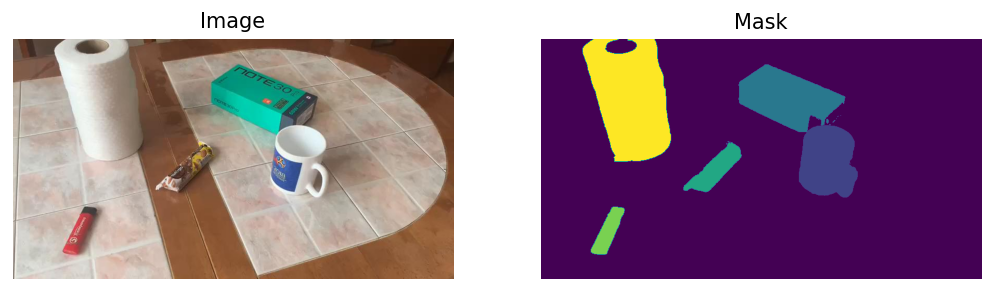

In [7]:
from skimage.io import imread
from skimage.transform import resize

import matplotlib.pyplot as plt


im = '/content/AI_item/dataset/img/frame0-00-00.00.jpg'
mask = '/content/AI_item/dataset/masks/frame0-00-00.00.png'

im = imread(im)
mask = imread(mask)
mask = resize(mask, (mask.shape[0], mask.shape[1]))

fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize=(10, 3), dpi=125)

ax[0].set_title('Image')
ax[0].set_axis_off()
ax[0].imshow(im)

ax[1].set_title('Mask')
ax[1].set_axis_off()
ax[1].imshow(mask * 255 / 7)

plt.show()
plt.close()

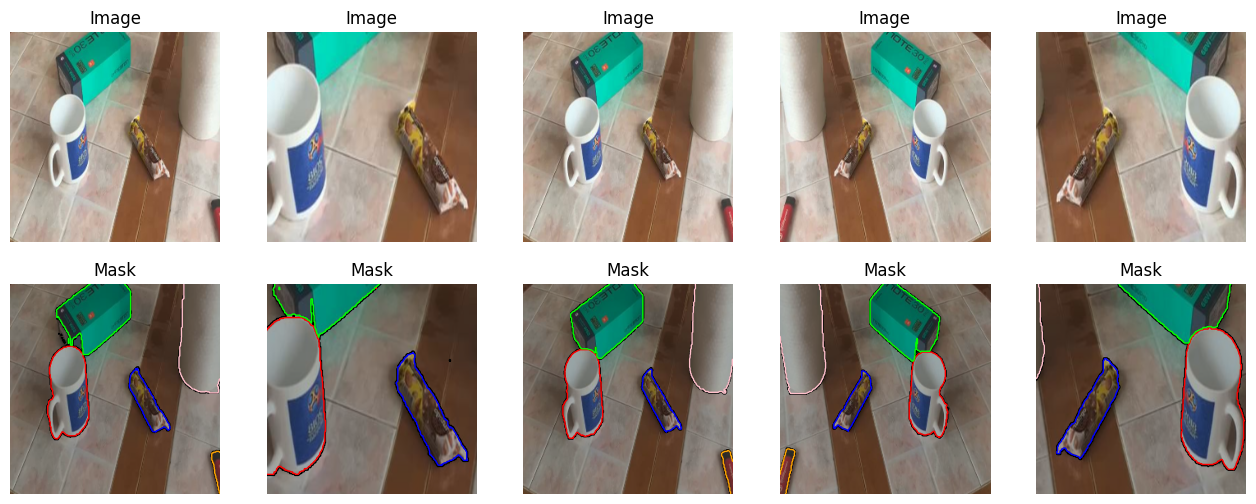

In [8]:
images_and_masks = list(dataset.take(5))

fig, ax = plt.subplots(nrows = 2, ncols = 5, figsize=(16, 6))

for i, (image, masks) in enumerate(images_and_masks):
    ax[0, i].set_title('Image')
    ax[0, i].set_axis_off()
    ax[0, i].imshow(image)

    ax[1, i].set_title('Mask')
    ax[1, i].set_axis_off()
    ax[1, i].imshow(image / 1.5)

    for channel in range(CLASSES):
        contours = measure.find_contours(np.array(masks[:,:,channel]))
        for contour in contours:
            ax[1, i].plot(contour[:, 1], contour[:, 0], linewidth=1, color=COLORS[channel])

plt.show()
plt.close()

## Разделим набор данных на обучающий и проверочный

In [9]:
train_dataset = dataset.take(2000).cache()
test_dataset = dataset.skip(2000).take(100).cache()

train_dataset = train_dataset.batch(8)
test_dataset = test_dataset.batch(8)

## Обозначим основные блоки модели

In [10]:
def input_layer(): # задает входной слой нейронной сети и устанавливает размер входных данных
    return tf.keras.layers.Input(shape=SAMPLE_SIZE + (3,))

def downsample_block(filters, size, batch_norm=True): # устанавливает блоки формирует Encoder
    initializer = tf.keras.initializers.GlorotNormal() # задает метод инициализации весовых коэффициентов

    result = tf.keras.Sequential()
    # включает сверточный слой
    result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))
    # добавляет слой пакетной нормализации
    if batch_norm:
        result.add(tf.keras.layers.BatchNormalization())
    # устанавливает активационную функцию
    result.add(tf.keras.layers.LeakyReLU())
    return result

def upsample_block(filters, size, dropout=False): # помогает формировать Decoder нейронной сети
    initializer = tf.keras.initializers.GlorotNormal()

    result = tf.keras.Sequential()
    # Transpose
    result.add(
        tf.keras.layers.Conv2DTranspose(filters, size, strides=2, padding='same',
                                        kernel_initializer=initializer, use_bias=False))

    result.add(tf.keras.layers.BatchNormalization())
    # Dropout
    if dropout:
        result.add(tf.keras.layers.Dropout(0.25))

    result.add(tf.keras.layers.ReLU())
    return result

def output_layer(size): # задает выходной слой
    initializer = tf.keras.initializers.GlorotNormal()
    return tf.keras.layers.Conv2DTranspose(CLASSES, size, strides=2, padding='same',
                                           kernel_initializer=initializer, activation='sigmoid')

## Построим U-NET подобную архитектуру

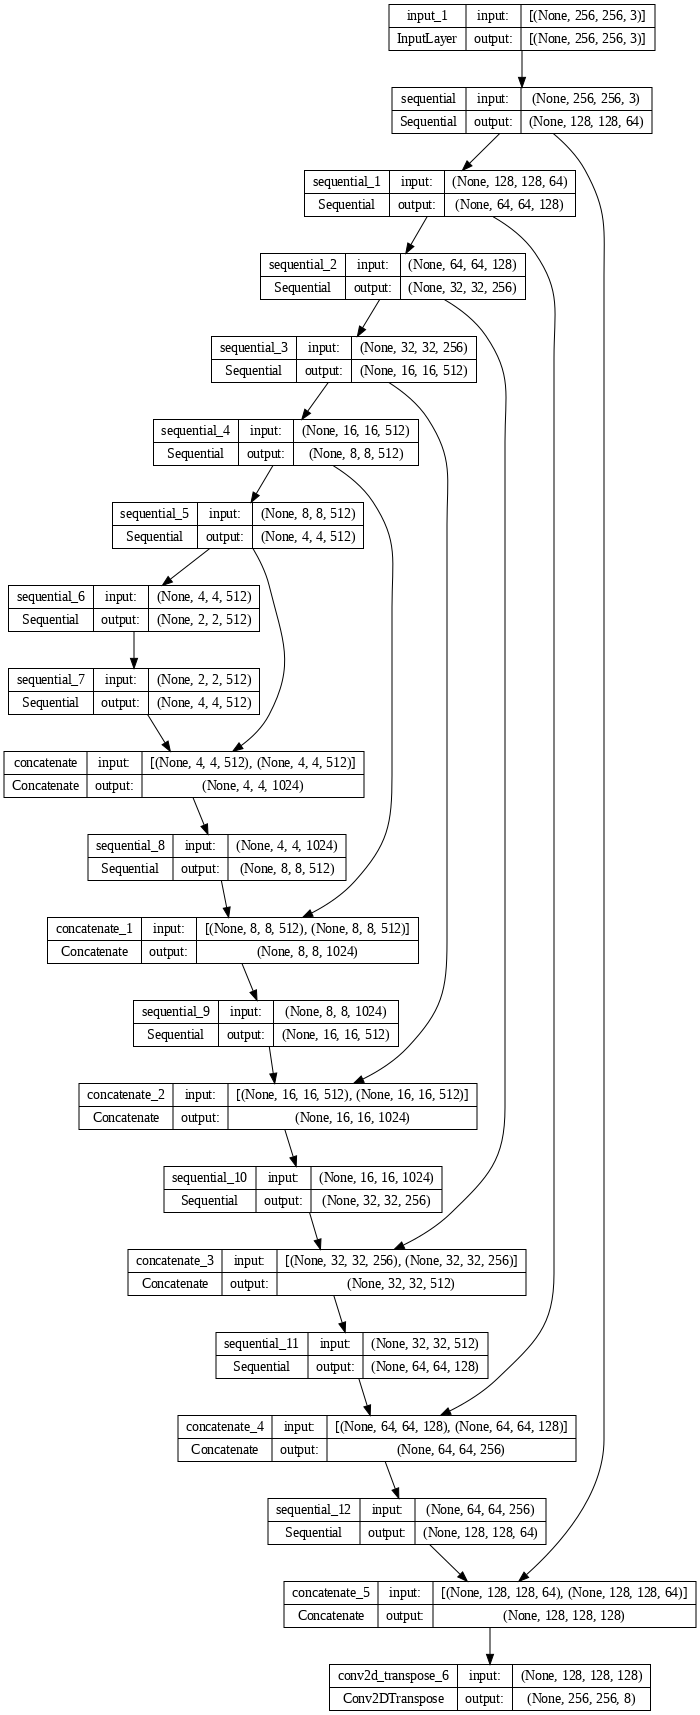

In [11]:
inp_layer = input_layer()

downsample_stack = [
    downsample_block(64, 4, batch_norm=False),
    downsample_block(128, 4),
    downsample_block(256, 4),
    downsample_block(512, 4),
    downsample_block(512, 4),
    downsample_block(512, 4),
    downsample_block(512, 4),
]

upsample_stack = [
    upsample_block(512, 4, dropout=True),
    upsample_block(512, 4, dropout=True),
    upsample_block(512, 4, dropout=True),
    upsample_block(256, 4),
    upsample_block(128, 4),
    upsample_block(64, 4)
]

out_layer = output_layer(4)

# Реализуем skip connections
x = inp_layer

downsample_skips = []

for block in downsample_stack:
    x = block(x)
    downsample_skips.append(x)

downsample_skips = reversed(downsample_skips[:-1])

for up_block, down_block in zip(upsample_stack, downsample_skips):
    x = up_block(x)
    x = tf.keras.layers.Concatenate()([x, down_block])

out_layer = out_layer(x)

unet_like = tf.keras.Model(inputs=inp_layer, outputs=out_layer)

tf.keras.utils.plot_model(unet_like, show_shapes=True, dpi=72)

## Определим метрики и функции потерь

In [12]:
# Метрика дает оценку точности результатов рабоыты нейронной сети
def dice_mc_metric(a, b): # a - ответ нейронной сети, b - результат, который должен получиться на самом деле, то чему старается научиться нейронная сеть
    a = tf.unstack(a, axis=3) # Распаковываю многоканальные изображения маски
    b = tf.unstack(b, axis=3)

    dice_summ = 0

    for i, (aa, bb) in enumerate(zip(a, b)): # ищем среднее значение коэффициента dice
        numenator = 2 * tf.math.reduce_sum(aa * bb) + 1
        denomerator = tf.math.reduce_sum(aa + bb) + 1
        dice_summ += numenator / denomerator

    avg_dice = dice_summ / CLASSES

    return avg_dice

def dice_mc_loss(a, b): # функция потери
    return 1 - dice_mc_metric(a, b)

def dice_bce_mc_loss(a, b): # комбинированная функция
    return 0.3 * dice_mc_loss(a, b) + tf.keras.losses.binary_crossentropy(a, b)

## Компилируем модель

In [13]:
unet_like.compile(optimizer='adam', loss=[dice_bce_mc_loss], metrics=[dice_mc_metric])

## Обучаем нейронную сеть и сохраняем результат

In [14]:
history_dice = unet_like.fit(train_dataset, validation_data=test_dataset, epochs=25, initial_epoch=0)

unet_like.save_weights('AI_item/networks/unet_like')

Epoch 1/25
250/250 [==============================] - 838s 3s/step - loss: 0.1911 - dice_mc_metric: 0.5423 - val_loss: 0.1327 - val_dice_mc_metric: 0.6475
Epoch 2/25
250/250 [==============================] - 45s 178ms/step - loss: 0.0362 - dice_mc_metric: 0.9087 - val_loss: 0.0261 - val_dice_mc_metric: 0.9429
Epoch 3/25
250/250 [==============================] - 44s 177ms/step - loss: 0.0132 - dice_mc_metric: 0.9766 - val_loss: 0.0192 - val_dice_mc_metric: 0.9687
Epoch 4/25
250/250 [==============================] - 44s 178ms/step - loss: 0.0115 - dice_mc_metric: 0.9798 - val_loss: 0.0259 - val_dice_mc_metric: 0.9619
Epoch 5/25
250/250 [==============================] - 45s 179ms/step - loss: 0.0103 - dice_mc_metric: 0.9822 - val_loss: 0.0103 - val_dice_mc_metric: 0.9830
Epoch 6/25
250/250 [==============================] - 45s 178ms/step - loss: 0.0093 - dice_mc_metric: 0.9843 - val_loss: 0.0100 - val_dice_mc_metric: 0.9847
Epoch 7/25
250/250 [==============================] - 44s 17

## Загружаем обученную модель

In [15]:
unet_like.load_weights('AI_item/networks/unet_like')

In [16]:
# описание модели
unet_like.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 sequential (Sequential)     (None, 128, 128, 64)         3072      ['input_1[0][0]']             
                                                                                                  
 sequential_1 (Sequential)   (None, 64, 64, 128)          131584    ['sequential[0][0]']          
                                                                                                  
 sequential_2 (Sequential)   (None, 32, 32, 256)          525312    ['sequential_1[0][0]']        
                                                                                              

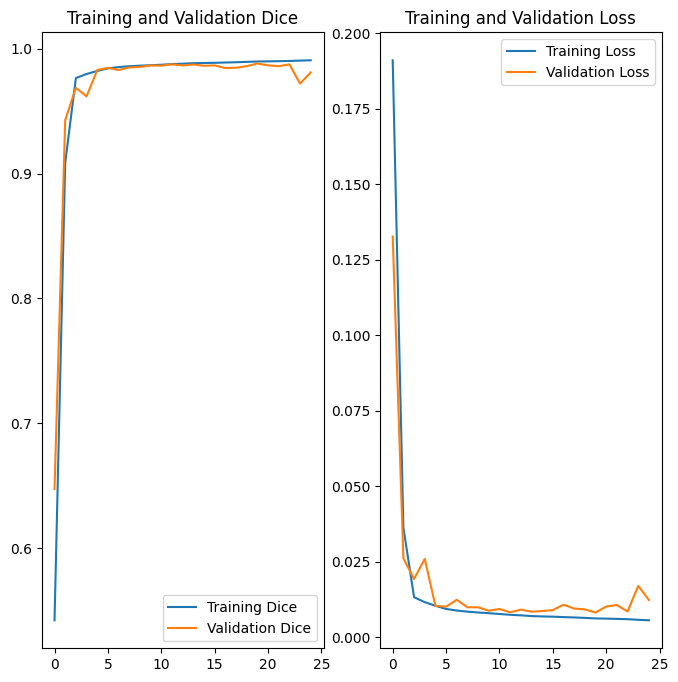

In [21]:
# результаты обучения
acc = history_dice.history['dice_mc_metric']
val_acc = history_dice.history['val_dice_mc_metric']

loss = history_dice.history['loss']
val_loss = history_dice.history['val_loss']

epochs = 25
epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Dice')
plt.plot(epochs_range, val_acc, label='Validation Dice')
plt.legend(loc='lower right')
plt.title('Training and Validation Dice')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Проверим работу сети на всех кадрах из видео

In [ ]:
rgb_colors = [
    (0,   0,   0),
    (255, 0,   0),
    (0,   255, 0),
    (0,   0,   255),
    (255, 165, 0),
    (255, 192, 203),
    (0,   255, 255),
    (255, 0,   255)
]

frames = sorted(glob.glob('AI_item/video/frames/*.jpg'))

for filename in frames:
    frame = imread(filename)
    sample = resize(frame, SAMPLE_SIZE)

    predict = unet_like.predict(sample.reshape((1,) +  SAMPLE_SIZE + (3,)))
    predict = predict.reshape(SAMPLE_SIZE + (CLASSES,))

    scale = frame.shape[0] / SAMPLE_SIZE[0], frame.shape[1] / SAMPLE_SIZE[1]

    frame = (frame / 1.5).astype(np.uint8)

    for channel in range(1, CLASSES):
        contour_overlay = np.zeros((frame.shape[0], frame.shape[1]))
        contours = measure.find_contours(np.array(predict[:,:,channel]))

        try:
            for contour in contours:
                rr, cc = polygon_perimeter(contour[:, 0] * scale[0],
                                           contour[:, 1] * scale[1],
                                           shape=contour_overlay.shape)

                contour_overlay[rr, cc] = 1

            contour_overlay = dilation(contour_overlay, disk(1))
            frame[contour_overlay == 1] = rgb_colors[channel]
        except:
            pass

    imsave(f'AI_item/video/processed/{os.path.basename(filename)}', frame)

1/1 [==============================] - 0s 20ms/step


In [ ]:
import cv2
import glob

images = glob.glob('/content/AI_item/video/processed/*.jpg')
images = sorted(images)

fourcc = cv2.VideoWriter_fourcc(*"mp4v")
video = cv2.VideoWriter(
    filename="output.mp4", fourcc=fourcc, fps=30.0, frameSize=(430, 430)
)

for image in images:
    frame = cv2.imread(image)
    frame = cv2.resize(frame, dsize=(430, 430))
    video.write(frame)

video.release()

In [ ]:
#-----------------------------

In [ ]:
import cv2

# Открытие видеофайла
video_capture = cv2.VideoCapture('video.mp4')

# Получение информации о видео
fps = video_capture.get(cv2.CAP_PROP_FPS)
frame_width = int(video_capture.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(video_capture.get(cv2.CAP_PROP_FRAME_HEIGHT))

# Создание объекта для записи видео
out = cv2.VideoWriter('output_video.mp4', cv2.VideoWriter_fourcc(*'mp4v'), fps, (frame_width, frame_height))

# Чтение и обработка каждого кадра видео
while video_capture.isOpened():
    ret, frame = video_capture.read()

    if not ret:
        break

    # Реверс видео
    frame = cv2.flip(frame, 1)

    # Запись обработанного кадра
    out.write(frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Освобождение ресурсов
video_capture.release()
out.release()
cv2.destroyAllWindows()


In [ ]:
from moviepy.editor import VideoFileClip
import numpy as np
import os
from datetime import timedelta

SAVING_FRAMES_PER_SECOND = 10

def format_timedelta(td):
    result = str(td)
    try:
        result, ms = result.split(".")
    except ValueError:
        return result + ".00".replace(":", "-")

    ms = round(int(ms) / 10000)
    return f"{result}.{ms:02}".replace(":", "-")


def main(video_file):
    video_clip = VideoFileClip(video_file)
    filename, _ = os.path.splitext(video_file)

    if not os.path.isdir(filename):
        os.mkdir(filename)

    saving_frames_per_second = min(video_clip.fps, SAVING_FRAMES_PER_SECOND)
    step = 1 / video_clip.fps if saving_frames_per_second == 0 else 1 / saving_frames_per_second

    for current_duration in np.arange(0, video_clip.duration, step):
        frame_duration_formatted = format_timedelta(timedelta(seconds=current_duration)).replace(":", "-")
        frame_filename = os.path.join(filename, f"frame{frame_duration_formatted}.jpg")

        video_clip.save_frame(frame_filename, current_duration)

video_file = 'output_video.mp4'
main(video_file)


In [ ]:
import os
import glob
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from skimage import measure
from skimage.io import imread, imsave
from skimage.transform import resize
from skimage.morphology import dilation, disk
from skimage.draw import polygon_perimeter

rgb_colors = [
    (0,   0,   0),
    (255, 0,   0),
    (0,   255, 0),
    (0,   0,   255),
    (255, 165, 0),
    (255, 192, 203),
    (0,   255, 255),
    (255, 0,   255)
]

frames = sorted(glob.glob('/content/output_video/*.jpg'))

for filename in frames:
    frame = imread(filename)
    sample = resize(frame, SAMPLE_SIZE)

    predict = unet_like.predict(sample.reshape((1,) +  SAMPLE_SIZE + (3,)))
    predict = predict.reshape(SAMPLE_SIZE + (CLASSES,))

    scale = frame.shape[0] / SAMPLE_SIZE[0], frame.shape[1] / SAMPLE_SIZE[1]

    frame = (frame / 1.5).astype(np.uint8)

    for channel in range(1, CLASSES):
        contour_overlay = np.zeros((frame.shape[0], frame.shape[1]))
        contours = measure.find_contours(np.array(predict[:,:,channel]))

        try:
            for contour in contours:
                rr, cc = polygon_perimeter(contour[:, 0] * scale[0],
                                           contour[:, 1] * scale[1],
                                           shape=contour_overlay.shape)

                contour_overlay[rr, cc] = 1

            contour_overlay = dilation(contour_overlay, disk(1))
            frame[contour_overlay == 1] = rgb_colors[channel]
        except:
            pass

    imsave(f'/content/output_video_processed/{os.path.basename(filename)}', frame) # создаем папку output_video_processed, чтобы вставить полученные фотографии

1/1 [==============================] - 0s 22ms/step


In [ ]:
import cv2
import glob

images = glob.glob('/content/output_video_processed/*.jpg')
images = sorted(images)

fourcc = cv2.VideoWriter_fourcc(*"mp4v")
video = cv2.VideoWriter(
    filename="output11.mp4", fourcc=fourcc, fps=30.0, frameSize=(430, 430)
)

for image in images:
    frame = cv2.imread(image)
    frame = cv2.resize(frame, dsize=(430, 430))
    video.write(frame)

video.release()

In [ ]:
#--------------------------

In [ ]:
import cv2

# Открытие видеофайла
video_capture = cv2.VideoCapture('video.mp4')

# Получение информации о видео
fps = video_capture.get(cv2.CAP_PROP_FPS)
frame_width = int(video_capture.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(video_capture.get(cv2.CAP_PROP_FRAME_HEIGHT))

# Создание объекта для записи видео
out = cv2.VideoWriter('output_video_1234.mp4', cv2.VideoWriter_fourcc(*'mp4v'), fps, (frame_width, frame_height))

# Чтение и обработка каждого кадра видео
while video_capture.isOpened():
    ret, frame = video_capture.read()

    if not ret:
        break

    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Запись обработанного кадра
    out.write(cv2.cvtColor(gray_frame, cv2.COLOR_GRAY2BGR))

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Освобождение ресурсов
video_capture.release()
out.release()
cv2.destroyAllWindows()


In [ ]:
from moviepy.editor import VideoFileClip
import numpy as np
import os
from datetime import timedelta

SAVING_FRAMES_PER_SECOND = 10

def format_timedelta(td):
    result = str(td)
    try:
        result, ms = result.split(".")
    except ValueError:
        return result + ".00".replace(":", "-")

    ms = round(int(ms) / 10000)
    return f"{result}.{ms:02}".replace(":", "-")


def main(video_file):
    video_clip = VideoFileClip(video_file)
    filename, _ = os.path.splitext(video_file)

    if not os.path.isdir(filename):
        os.mkdir(filename)

    saving_frames_per_second = min(video_clip.fps, SAVING_FRAMES_PER_SECOND)
    step = 1 / video_clip.fps if saving_frames_per_second == 0 else 1 / saving_frames_per_second

    for current_duration in np.arange(0, video_clip.duration, step):
        frame_duration_formatted = format_timedelta(timedelta(seconds=current_duration)).replace(":", "-")
        frame_filename = os.path.join(filename, f"frame{frame_duration_formatted}.jpg")

        video_clip.save_frame(frame_filename, current_duration)

video_file = 'output_video_1234.mp4'
main(video_file)


In [ ]:
import os
import glob
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from skimage import measure
from skimage.io import imread, imsave
from skimage.transform import resize
from skimage.morphology import dilation, disk
from skimage.draw import polygon_perimeter

rgb_colors = [
    (0,   0,   0),
    (255, 0,   0),
    (0,   255, 0),
    (0,   0,   255),
    (255, 165, 0),
    (255, 192, 203),
    (0,   255, 255),
    (255, 0,   255)
]

frames = sorted(glob.glob('/content/output_video_1234/*.jpg'))

for filename in frames:
    frame = imread(filename)
    sample = resize(frame, SAMPLE_SIZE)

    predict = unet_like.predict(sample.reshape((1,) +  SAMPLE_SIZE + (3,)))
    predict = predict.reshape(SAMPLE_SIZE + (CLASSES,))

    scale = frame.shape[0] / SAMPLE_SIZE[0], frame.shape[1] / SAMPLE_SIZE[1]

    frame = (frame / 1.5).astype(np.uint8)

    for channel in range(1, CLASSES):
        contour_overlay = np.zeros((frame.shape[0], frame.shape[1]))
        contours = measure.find_contours(np.array(predict[:,:,channel]))

        try:
            for contour in contours:
                rr, cc = polygon_perimeter(contour[:, 0] * scale[0],
                                           contour[:, 1] * scale[1],
                                           shape=contour_overlay.shape)

                contour_overlay[rr, cc] = 1

            contour_overlay = dilation(contour_overlay, disk(1))
            frame[contour_overlay == 1] = rgb_colors[channel]
        except:
            pass

    imsave(f'/content/output_video_black_processed/{os.path.basename(filename)}', frame) # создаем папку output_video_black_processed, чтобы вставить полученные фотографии

1/1 [==============================] - 0s 37ms/step


In [ ]:
import cv2
import glob

images = glob.glob('/content/output_video_black_processed/*.jpg')
images = sorted(images)

fourcc = cv2.VideoWriter_fourcc(*"mp4v")
video = cv2.VideoWriter(
    filename="output111.mp4", fourcc=fourcc, fps=30.0, frameSize=(430, 430)
)

for image in images:
    frame = cv2.imread(image)
    frame = cv2.resize(frame, dsize=(430, 430))
    video.write(frame)

video.release()